# Vectorizing text

There are multiple ways to vectorize text. I'll show two here, TF-IDF, which builds vectors for documents based on relative word frequency and pretrained models whihch leverage information from other corpuses.

In [1]:
import pandas as pd
import spacy
import umap
import numpy as np 
from pathlib import Path
import sys
sys.path.append("..")

%matplotlib inline
%load_ext autoreload
%autoreload 2

from ml_editor.data_processing import format_raw_df, get_split_by_author

data_path = Path('../data/writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())

train_author, test_author = get_split_by_author(df[df["is_question"]])

/Users/emmanuel.ameisen/ml_editor/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## TF-IDF on ngrams

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

questions = train_author[train_author["is_question"]]
raw_text = questions["body_text"]
sent_labels = questions["AcceptedAnswerId"].notna()

sent_labels.value_counts()

True     2907
False    2769
Name: AcceptedAnswerId, dtype: int64

In [3]:
# Create an instance of a tfidf vectorizer, 
# We could use CountVectorizer for a non normalized version
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_features=2**21)

# Fit our vectorizer to questions in our dataset
# Returns an array of vectorized text
bag_of_words = vectorizer.fit_transform(raw_text)

bag_of_words.shape

(5676, 27381)

Let's visualize the embeddings by projecting them to two dimensions using UMAP

In [4]:
umap_embedder = umap.UMAP()
umap_bow = umap_embedder.fit_transform(bag_of_words)

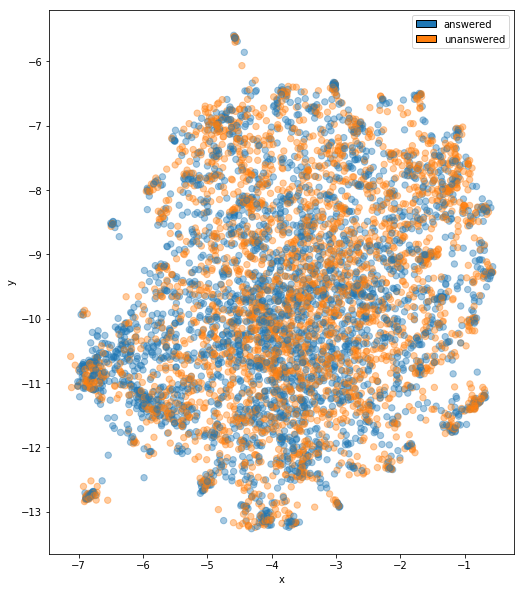

In [5]:
from ml_editor.data_visualization import plot_embeddings

plot_embeddings(umap_bow, sent_labels)

## Pre-trained word embeddings

Here, we load word vectors that were trained on a different corpus and use them to represent our documents

In [6]:
# Load a large model, and disable pipeline unnecessary parts for our task
# This speeds up the vectorization process significantly
# See https://spacy.io/models/en#en_core_web_lg for details about the model
nlp = spacy.load('en_core_web_lg', disable=["parser", "tagger", "ner", "textcat"])

In [7]:
# Get the vector for each of our questions
# By default, the vector returned is the average of all vectors in the sentence
# See https://spacy.io/usage/vectors-similarity for more
spacy_emb = train_author[train_author["is_question"]]["body_text"].apply(lambda x: nlp(x).vector)
embeddings = np.vstack(spacy_emb)

In [8]:
umap_embedder = umap.UMAP()
umap_emb = umap_embedder.fit_transform(embeddings)

Let's visualize the pretrained embeddings by using UMAP

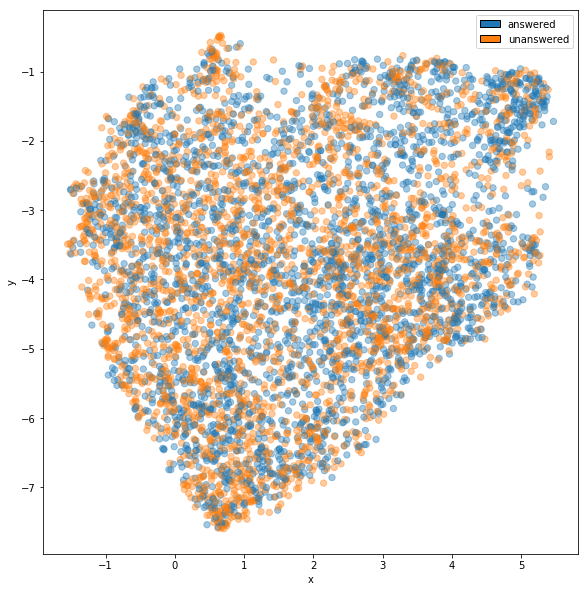

In [9]:
plot_embeddings(umap_emb, sent_labels)

The topology of our dataset looks different because our embedding method is different. The underlying data however, is the same